# Matching FHDs to GLEAM data

In [1]:
import sys 
sys.path.append('/home/kelcey/hera/Washington/uwchamp2017/fits_functions')
sys.path.append('/home/kelcey/hera/Washington/uwchamp2017')

import clusterer as clst
import fits_functions as ff

/home/kelcey/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [32]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from astropy import units as u
import glob
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from pylab import *
from astropy.table import Table
from astropy.coordinates import match_coordinates_sky
from itertools import cycle
import scipy.integrate as integrate
from scipy.interpolate import griddata
from itertools import permutations
from itertools import combinations

### Below cell configures the Matplotlib graphs to look nice

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')

### List of colors in Matplotlib to create random arrays of color.

In [4]:
cols = ['gray', 'silver', 'rosybrown', 'firebrick', 'red', 'darksalmon', 'sienna', 'sandybrown', 'tan', 
       'gold', 'darkkhaki', 'olivedrab', 'chartreuse', 'darkgreen', 'seagreen', 'mediumspringgreen',
       'lightseagreen', 'darkcyan', 'darkturquoise', 'deepskyblue', 'slategray', 'royalblue', 'navy', 
       'blue', 'mediumpurple', 'darkorchid', 'm', 'mediumvioletred', 'palevioletred', 'lightcoral', 
       'maroon', 'coral', 'peachpuff', 'darkorange', 'orange', 'darkgoldenrod', 'olive', 'yellowgreen',
       'lawngreen', 'lightgreen', 'g', 'mediumseagreen', 'darkslategrey', 'cadetblue', 'skyblue', 
       'dodgerblue']

### Below are two functions are from clussterer.py that needed to be rewritten becasue the keywords did not match the keywords from the GLEAM Catalog.

In [5]:
def separator_catalog(data):
    '''
    The separator splits all data which has been read in by the collector
    into individual lists for point sources and extended sources.
    
    This is primarily written to be used by the Seeker.
    
    Args:
        data: The variable assigned to the IDL .sav file which has been
            read in by the collector.

    Returns:
        data: A dictonary containing two keys:
            1. "extsources": The same data structure containing only extended sources.
            2. "psources": The same data structure containing only point sources.
    '''

    # A source is determined to be a point source if
    # it does not contain any extended components.
    point_data = [[data['data'][i]['catalog'][j]
                   for j in range(len(data['data'][i]['catalog']))
                  if data['data'][i]['catalog'][j]['EXTEND'] is None]
                  for i in range(len(data['data']))]

    # A source is determined to be an extended source if
    # it does contain any extended components.
    extended_data = [[data['data'][i]['catalog'][j]
                      for j in range(len(data['data'][i]['catalog']))
                      if data['data'][i]['catalog'][j]['EXTEND']
                      is not None]
                     for i in range(len(data['data']))]

    return {'extsources': extended_data, 'psources': point_data}

In [6]:
def seeker_catalog(data):
    """
    The seeker splits all data which has been read in by the collector
    into individual lists for RA, DEC, FLUX, XX, and YY values.
    Separate lists are made for point sources, extended sources,
    and all sources.
    
    Args:
        data: The variable assigned to the IDL .sav file which has been
            read in by the collector.

    Returns:
        Separated lists for ID, X, Y, RA, DEC, STON, FREQ, ALPHA, GAIN, FLAG,
        XX, YY, XY, YX, I, Q, U, and V values for point sources, extended sources,
        and all sources.
    """

    # Separating data into point sources and extended sources.
    separated = separator_catalog(data)

    # Creating individual lists for RA, DEC, FLUX, XX, and YY values
    # for point sources.
    point_sources_ID = [[separated['psources'][i][j]['ID']
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_X = [[separated['psources'][i][j]['X']
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_Y = [[separated['psources'][i][j]['Y']
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_RA = [[separated['psources'][i][j]['RA']
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_DEC = [[separated['psources'][i][j]['DEC']
                          for j in range(len(separated['psources'][i]))]
                         for i in range(len(separated['psources']))]
    point_sources_STON = [[separated['psources'][i][j]['STON']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_FREQ = [[separated['psources'][i][j]['FREQ']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_ALPHA = [[separated['psources'][i][j]['ALPHA']
                            for j in range(len(separated['psources'][i]))]
                           for i in range(len(separated['psources']))]
    point_sources_GAIN = [[separated['psources'][i][j]['GAIN']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_FLAG = [[separated['psources'][i][j]['FLAG']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_XY = [[separated['psources'][i][j]['FLUX']['XY'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_YX = [[separated['psources'][i][j]['FLUX']['YX'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_I = [[separated['psources'][i][j]['FLUX']['I'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_Q = [[separated['psources'][i][j]['FLUX']['Q'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_U = [[separated['psources'][i][j]['FLUX']['U'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_V = [[separated['psources'][i][j]['FLUX']['V'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]

    # Creating individual lists for RA, DEC, FLUX, XX, and YY values
    # for extended sources.
    EO_sources_ID = [[[separated['extsources'][i][j]['EXTEND']['ID'][k]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['ID']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_X = [[[separated['extsources'][i][j]['EXTEND']['X'][k]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['X']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_Y = [[[separated['extsources'][i][j]['EXTEND']['Y'][k]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['Y']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k]
                        for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))]
                       for j in range(len(separated['extsources'][i]))]
                      for i in range(len(separated['extsources']))]
    EO_sources_STON = [[[separated['extsources'][i][j]['EXTEND']['STON'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['STON']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_FREQ = [[[separated['extsources'][i][j]['EXTEND']['FREQ'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['FREQ']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_ALPHA = [[[separated['extsources'][i][j]['EXTEND']['ALPHA'][k]
                          for k in range(len(separated['extsources'][i][j]['EXTEND']['ALPHA']))]
                         for j in range(len(separated['extsources'][i]))]
                        for i in range(len(separated['extsources']))]
    EO_sources_GAIN = [[[separated['extsources'][i][j]['EXTEND']['GAIN'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['GAIN']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_FLAG = [[[separated['extsources'][i][j]['EXTEND']['FLAG'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['FLAG']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_XY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XY'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_YX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YX'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_I = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_Q = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['Q'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_U = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['U'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_V = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['V'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]

    # Fixing RA values to range between -180 and +180.
    for i in range(len(data['data'])):
        for j in range(len(EO_sources_RA[i])):
            for k in range(len(EO_sources_RA[i][j])):
                if EO_sources_RA[i][j][k] > 180:
                    EO_sources_RA[i][j][k] -= 360
        for j in range(len(point_sources_RA[i])):
            if point_sources_RA[i][j] > 180:
                point_sources_RA[i][j] -= 360

    # Adding point source and extended source lists to create
    # lists for RA, DEC, FLUX, XX, and YY values for all sources.
    all_RA = [[point_sources_RA[i][j]
               for j in range(len(point_sources_RA[i]))] +
              [EO_sources_RA[i][j][k]
              for j in range(len(EO_sources_RA[i]))
              for k in range(len(EO_sources_RA[i][j]))]
              for i in range(len(data['data']))]
    all_DEC = [[point_sources_DEC[i][j]
                for j in range(len(point_sources_DEC[i]))] +
               [EO_sources_DEC[i][j][k]
               for j in range(len(EO_sources_DEC[i]))
               for k in range(len(EO_sources_DEC[i][j]))]
               for i in range(len(data['data']))]
    all_I = [[point_sources_I[i][j]
              for j in range(len(point_sources_I[i]))] +
             [EO_sources_I[i][j][k]
             for j in range(len(EO_sources_I[i]))
             for k in range(len(EO_sources_I[i][j]))]
             for i in range(len(data['data']))]
    all_XX = [[point_sources_XX[i][j]
               for j in range(len(point_sources_XX[i]))] +
              [EO_sources_XX[i][j][k]
              for j in range(len(EO_sources_XX[i]))
              for k in range(len(EO_sources_XX[i][j]))]
              for i in range(len(data['data']))]
    all_YY = [[point_sources_YY[i][j]
               for j in range(len(point_sources_YY[i]))] +
              [EO_sources_YY[i][j][k]
              for j in range(len(EO_sources_YY[i]))
              for k in range(len(EO_sources_YY[i][j]))]
              for i in range(len(data['data']))]
    all_BEAM = [np.asarray(np.asarray(all_XX[i]) +
                np.asarray(all_YY[i])) / np.asarray(all_I[i])
                for i in range(len(data['data']))]

    return {'point_sources_ID': point_sources_ID,
            'point_sources_X': point_sources_X,
            'point_sources_Y': point_sources_Y,
            'point_sources_RA': point_sources_RA,
            'point_sources_DEC': point_sources_DEC,
            'point_sources_STON': point_sources_STON,
            'point_sources_FREQ': point_sources_FREQ,
            'point_sources_ALPHA': point_sources_ALPHA,
            'point_sources_GAIN': point_sources_GAIN,
            'point_sources_FLAG': point_sources_FLAG,
            'point_sources_XX': point_sources_XX,
            'point_sources_YY': point_sources_YY,
            'point_sources_XY': point_sources_XY,
            'point_sources_YX': point_sources_YX,
            'point_sources_I': point_sources_I,
            'point_sources_Q': point_sources_Q,
            'point_sources_U': point_sources_U,
            'point_sources_V': point_sources_V,
            'EO_sources_ID': EO_sources_ID,
            'EO_sources_X': EO_sources_X,
            'EO_sources_Y': EO_sources_Y,
            'EO_sources_RA': EO_sources_RA,
            'EO_sources_DEC': EO_sources_DEC,
            'EO_sources_STON': EO_sources_STON,
            'EO_sources_FREQ': EO_sources_FREQ,
            'EO_sources_ALPHA': EO_sources_ALPHA,
            'EO_sources_GAIN': EO_sources_GAIN,
            'EO_sources_FLAG': EO_sources_FLAG,
            'EO_sources_XX': EO_sources_XX,
            'EO_sources_YY': EO_sources_YY,
            'EO_sources_XY': EO_sources_XY,
            'EO_sources_YX': EO_sources_YX,
            'EO_sources_I': EO_sources_I,
            'EO_sources_Q': EO_sources_Q,
            'EO_sources_U': EO_sources_U,
            'EO_sources_V': EO_sources_V,
            'all_RA': all_RA, 'all_DEC': all_DEC, 'all_I': all_I,
            'all_XX': all_XX, 'all_YY': all_YY, 'all_BEAM': all_BEAM}

## Define the GLEAM catalog and import it so this does not have to be done inside a for loop. (This may take 5-10 minutes to run)

In [7]:
directory = '/home/kelcey/hera/Washington/uwashchamp2019/source_array_data/'
paths = glob.glob(directory + '*.sav')

In [8]:
GLEAM_path = '/home/kelcey/hera/Washington/GLEAM_v2_plus_rlb2019.sav'
GLEAM_data = clst.collector(GLEAM_path)
GLEAM_seek = seeker_catalog(GLEAM_data)

In [9]:
GLEAM_seek.keys()

['point_sources_DEC',
 'all_YY',
 'point_sources_YX',
 'EO_sources_Q',
 'point_sources_ID',
 'EO_sources_I',
 'point_sources_STON',
 'all_DEC',
 'EO_sources_DEC',
 'EO_sources_FREQ',
 'EO_sources_YX',
 'EO_sources_YY',
 'all_BEAM',
 'all_I',
 'point_sources_RA',
 'all_XX',
 'EO_sources_ALPHA',
 'point_sources_V',
 'point_sources_U',
 'EO_sources_FLAG',
 'EO_sources_XX',
 'EO_sources_X',
 'point_sources_Q',
 'point_sources_ALPHA',
 'point_sources_XX',
 'point_sources_XY',
 'point_sources_YY',
 'point_sources_GAIN',
 'EO_sources_RA',
 'point_sources_Y',
 'point_sources_X',
 'EO_sources_V',
 'point_sources_FREQ',
 'all_RA',
 'EO_sources_Y',
 'EO_sources_ID',
 'EO_sources_GAIN',
 'EO_sources_U',
 'point_sources_FLAG',
 'EO_sources_XY',
 'point_sources_I',
 'EO_sources_STON']

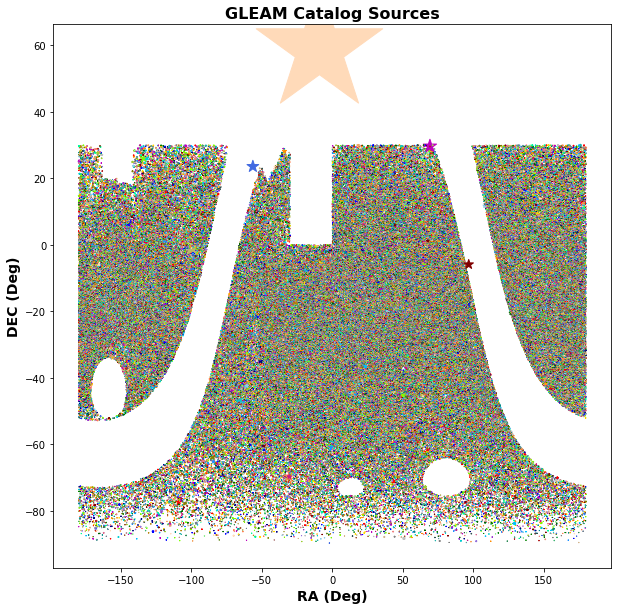

In [85]:
cols = np.random.choice(cols, len(np.array(GLEAM_seek['point_sources_RA'][0])))
plt.scatter(table['RA'], table['DEC'], s = table['Mag GLEAM'], marker = '*', color = cols)
plt.title('GLEAM Catalog Sources')
plt.xlabel('RA (Deg)')
plt.ylabel('DEC (Deg)');

## The Matching Algorithm

**WARNING**: This cell will take an hour or two to run

What follows is a line-by-line breakdown of the below algorithm. It should take a series of .sav files and return a Data Frame of each of the observations matched to the GLEAM catalog.

* Function Call: When the function is called, it requires two arguments, directory and GLEAM_seek. Directory is an absolute path on your computer that contains a set of .sav files. GLEAM_seek is the GLEAM catalog after it has been run through the seeker_catalog function defiened above. This is identical to clstr.seeker but with a few keywords changed to acomodate the way the GLEAM file is stored. 

* Line 11: Paths is defined here as a series of absoulte paths to all the .sav files in the directory provided when the function is called. Glob Documentation: https://docs.python.org/2/library/glob.html

* Lines 14-16: These lines open the GLEAM_seek object provided on function call and extract the RA, DEC, and I Band Flux.

* Lines 19-20: The Pandas DataFrame that will be returned at the end of the function is created. It now has 3 columns, each containing the information imported in lines 14-16. N = 0 is also defined here to be used later in future column names.

* Line 25: This is the begining of the major for loop. It will loop through every path in the paths variable created in line 11. The paths variable is cutoff here to only include the first 20 .sav files in the directory. This can be adjusted based on computer strength and time available to run the code. As is, this coded will take at least an hour to loop over these first 20 files.

* Lines 28-29: The N variable defined outside of the for loop is increased by one to track the observation number. The clst.collector functiton is called to organize the data.

* Lines 31-59: This is where each file is opened and the information about their components are collected. d_s is where the information about every object in the observation is stored. Each of these individual objects is looped through and checked for an extended component. If there is no extetnded component for an object, it is considered a point source. If there is an extended component, then the object can be considered a point source or it can be considered as a series of points. These points have their own RAs, DECs, and I Band Fluxes. A few arrays are built in this step. The point source RA, DEC, and I-Mag arrays will always be assigned a value regardless of the extended components. If there is point source information, but not extended component information, the information for the point source is added to the information arrays. This allows for simpler data processing later on. 

* Lines 66-68: This is the section of the function that matches the observation to GLEAM. It utilizes astropy's match_to_catalog_sky function. The documentation for this function can be found here: https://docs.astropy.org/en/stable/coordinates/matchsep.html (Matching Catalogs Section, First Block). First, the RAs and DECs from both GLEAM and the observation are converted into a list of SkyCoordinates, with units defined as Degrees. The match_to_catalog_sky function will return 3 arrays when given these two arrays of coordinates, the idx, d2d, and d3d arrays. The d3d array deals with 3-Dimensional distances and, since we feed the function no information about these, it returns an empty d3d array. We still call it beacuse it is part of the syntax of match_to_catalog_sky. The idx array is an array of indices that indicate positions of stars in the observation in GLEAM. For example, if an idx array that looked something like idx = [50, 1, 15] was returned, that would mean that the 50th object in our observation was the closest match for the 0th object in GLEAM, the 1st object in the observation mathced the 1st object in GLEAM, and the 15th object in our observation matched the 2nd object in GLEAM. This array is an important tool because it allows us to index any information about the observation with the idx array to return a new array of the data, but re-ordered to be the same length and in the same order as GLEAM. The other array returned by the match_to_catalog_sky function is the d2d array. This array contains the matching distance between objects in GLEAM and objects in our observation. It is already in the same order and shape as the idx array. This array is very important because it allows us to throw out mismatched pairs. The function starts with an object in GLEAM and looks for the closest object in the observation. That match could be a few hundred arc seconds away, or a few tens of degrees. This d2d array will be used to constriain our matches.

* Lines 72-79: This is the section where the matches are constrained and poor matches are thrown out. While the d2d array is an important tool, the change in magnitude must also be considered. The resolution of the MWA array that recorded this data is around 100 arc seconds. This low resolution means that matching based only on distance between matchces would be a poor choice. Here, we limit the matching distance to 0.1 Degreees (360 Arc seconds) to cast a bit of a wide net for matchces. This is then further constrainend to only include objects within  +/- $3 \over 4$ the GLEAM magnitude. This ensures that a source of 0.05 Jy won't macth with brighter 20-30 Jy sources in the same area. Anything that does not match these criteria is replaced with a 0 for the magnitude of that observation. This allows us to easily throw out data when working with this DataFrames, but also allows us to keep other information about the source in case we want to look at the match anyway.

* Lines 82-91: Here is where all the information is collected and stored in the DataFrame created in line 20. The idx array is utulized to order the data so that it has the same order and shape as GLEAM. New columns are created in the DataFrame for each of these new sets of data, utilizing the N variable that was changed at the begining of the for loop. The Data Frame is returned.

In [9]:
def match_to_gleam(directory, GLEAM_seek):
    """
    Matches all the .sav files in a given directory with GLEAM
    
    directory is an absolute path to the data
    
    GLEAM_seek is the GLEAM catalog after being run through the corrected seeker function
    
    """
    #Create paths to all the .sav files in the specified directory
    paths = glob.glob(directory + '*.sav')
    
    #Load the GLEAM data
    ra_gleam = np.array(GLEAM_seek['point_sources_RA'][0])
    dec_gleam = np.array(GLEAM_seek['point_sources_DEC'][0])
    imag_gleam = np.array(GLEAM_seek['point_sources_I'][0])
    
    #Create a Pandas Data Frame with the RA, DEC, and GLEAM Magnitudes
    n=0
    df = pd.DataFrame({'RA': ra_gleam,'Mag GLEAM': imag_gleam,  'DEC' : dec_gleam})
    
    #Look at each path in the directory
    #WARNING: 2 files takes 15-20 minutes to load. DO NOT change the indecies unless 
    #you are prepared to wait a while. There are over 300k stars in GLEAM
    for path in paths[0:20]:
        
        #Collect the data for each path
        n = n + 1
        data = clst.collector(path)
        
        eo = []
        eo_ra = []
        eo_dec = []
        ps_RA = []
        ps_DEC = []
        i_mag = []
        EO_imag = []

        d_s = data['data'][0]['source_array']
     
        for d in d_s:
            if d['EXTEND'] is None:
                ps_RA.append(d['RA'])
                ps_DEC.append(d['DEC'])
                EO_imag.append(d['FLUX']['I'])
                eo_ra.append(d['RA'])
                eo_dec.append(d['DEC'])
                i_mag.append(d['FLUX']['I'])
                
            else:
                ps_RA.append(d['RA'])
                ps_DEC.append(d['DEC'])
                EOmags = []
                for i in range(0, d['EXTEND']['FLUX'].shape[0]):
                    EOmags.append(d['EXTEND']['FLUX'][i]['I'])
                EO_imag.append(np.array(EOmags))
                eo_ra.append(d['EXTEND']['RA'])
                eo_dec.append(d['EXTEND']['DEC'])
                i_mag.append(d['FLUX']['I'])
                
        #Match this path with the GLEAM catalog
        #idx: an array of indices corresponding to matches
        #d2d: the two dimensional distances between these matches
        #d3d: three dimensional distances between matches. This array is blank becasue we do 
        #not have 3 dimensional data, but the match_to_catalog_sky function requires it anyway
        catalog = SkyCoord(ra=ps_RA*u.deg, dec=ps_DEC*u.deg)  
        c = SkyCoord(ra=ra_gleam*u.deg, dec=dec_gleam*u.deg)  
        idx, d2d, d3d = c.match_to_catalog_sky(catalog)  
               
        #Possible source of error because the below statement is worded a little strange
        #Only return matches within one degree 
        mags = []
        imags = np.array(i_mag)[idx]
        nums = np.arange(0, len(idx))
        for num in nums:
            if (d2d[num] < (0.1*u.deg)) and ((imags[num] > imag_gleam[num] + (3/4)*imag_gleam[num]) or (imags[num] > (3/4)*imag_gleam[num])):
                mags.append(imags[num])
            else: 
                mags.append(0)

        #Add a new column to the data frame with the information from this path      
        s_mag = pd.Series(mags)
        s_dist = pd.Series(d2d)
        df['Mag {}'.format(n)] = s_mag
        df['Distance {}'.format(n)] = s_dist
        
        df['RA {}'.format(n)] = np.array(ps_RA)[idx]
        df['DEC {}'.format(n)] = np.array(ps_DEC)[idx]
        df['EO RA {}'.format(n)] = np.array(eo_ra)[idx]
        df['EO DEC {}'.format(n)] = np.array(eo_dec)[idx]
        df['EO Mag {}'.format(n)] = np.array(EO_imag)[idx]
        
    return df

In [10]:
directory = '/home/kelcey/hera/Washington/uwashchamp2019/source_array_data/'
table = match_to_gleam(directory, GLEAM_seek)
table

,DEC,Mag GLEAM,RA,Mag 1,Distance 1,RA 1,DEC 1,EO RA 1,EO DEC 1,EO Mag 1,...,EO RA 19,EO DEC 19,EO Mag 19,Mag 20,Distance 20,RA 20,DEC 20,EO RA 20,EO DEC 20,EO Mag 20
0,-89.687309,0.303373,-2.085632,0,2.719350,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.541911,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
1,-89.213310,0.227618,-21.663757,0,2.464659,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.734564,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
2,-89.155968,0.451251,-11.600952,0,2.598894,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.598014,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
3,-88.750610,1.528642,-14.703156,0,2.551081,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.672655,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
4,-88.740990,0.290795,-41.215271,0,1.983217,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,42.224024,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
5,-88.825325,0.315769,-10.407288,0,2.634402,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.579083,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
6,-88.430840,0.253299,-8.097626,0,2.769716,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.517054,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
7,-88.290367,0.113284,-24.161621,0,2.348060,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.987415,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
8,-88.139534,0.416708,-15.071472,0,2.655384,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.734315,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"
9,-88.058319,0.426634,-0.703857,0,3.124142,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]","[[0.84616417], [0.24415675]]",...,"[58.39328, 58.33612]","[-52.333862, -52.370705]","[[0.20628607], [0.04563221]]",0,41.256675,78.221931,-48.406380,"[78.21236, 78.26817]","[-48.399612, -48.439014]","[[14.310676], [2.9676573]]"


In [113]:
mgs= np.array(table['Mag 3'])
i = mgs>15
table.loc[i]

,DEC,Mag GLEAM,RA,Mag 1,Distance 1,RA 1,DEC 1,EO RA 1,EO DEC 1,EO Mag 1,...,EO RA 14,EO DEC 14,EO Mag 14,Mag 15,Distance 15,RA 15,DEC 15,EO RA 15,EO DEC 15,EO Mag 15
112608,-16.071735,20.848221,17.070896,0,35.188262,49.514122,-36.342167,49.5141,-36.3422,[1.1049418],...,17.0715,-16.0739,[21.195793],0,30.688943,43.657200,-35.581242,"[43.67455, 43.66488, 43.637554, 43.683224, 43....","[-35.603268, -35.567196, -35.56303, -35.604954...","[[0.060251653], [0.06138997], [0.061258655], [..."
115437,-15.336476,18.884764,20.112600,0,33.540802,49.514122,-36.342167,49.5141,-36.3422,[1.1049418],...,20.1159,-15.338,[19.339624],0,29.199414,43.657200,-35.581242,"[43.67455, 43.66488, 43.637554, 43.683224, 43....","[-35.603268, -35.567196, -35.56303, -35.604954...","[[0.060251653], [0.06138997], [0.061258655], [..."
124006,-12.991464,18.142969,33.903378,0,26.847234,52.965439,-33.473339,52.9654,-33.4733,[1.216961],...,"[28.834295, 28.831985, 28.832882, 28.83391, 28...","[-14.806651, -14.805671, -14.804958, -14.80505...","[[0.09719052], [0.08524064], [0.07580078], [0....",0,22.582219,47.979668,-31.499968,47.9797,-31.5,[2.7026448]
131257,-2.127093,24.436581,9.584585,0,50.232195,49.967476,-35.720005,"[49.98173, 49.96733, 49.95952, 49.955498, 49.9...","[-35.668297, -35.773323, -35.772022, -35.7711,...","[[0.6399747], [0.10464835], [0.103230335], [0....",...,9.58723,-2.12362,[24.785337],0,45.988379,43.657200,-35.581242,"[43.67455, 43.66488, 43.637554, 43.683224, 43....","[-35.603268, -35.567196, -35.56303, -35.604954...","[[0.060251653], [0.06138997], [0.061258655], [..."
132504,-1.244002,0.184713,9.267570,0,51.093991,49.967476,-35.720005,"[49.98173, 49.96733, 49.95952, 49.955498, 49.9...","[-35.668297, -35.773323, -35.772022, -35.7711,...","[[0.6399747], [0.10464835], [0.103230335], [0....",...,9.2704,-1.14852,[17.135828],0,46.873231,43.657200,-35.581242,"[43.67455, 43.66488, 43.637554, 43.683224, 43....","[-35.603268, -35.567196, -35.56303, -35.604954...","[[0.060251653], [0.06138997], [0.061258655], [..."
132631,-1.152862,16.889624,9.266866,0,51.161292,49.967476,-35.720005,"[49.98173, 49.96733, 49.95952, 49.955498, 49.9...","[-35.668297, -35.773323, -35.772022, -35.7711,...","[[0.6399747], [0.10464835], [0.103230335], [0....",...,9.2704,-1.14852,[17.135828],0,46.944524,43.657200,-35.581242,"[43.67455, 43.66488, 43.637554, 43.683224, 43....","[-35.603268, -35.567196, -35.56303, -35.604954...","[[0.060251653], [0.06138997], [0.061258655], [..."
134491,-1.391537,16.604322,14.394592,0,47.596554,49.967476,-35.720005,"[49.98173, 49.96733, 49.95952, 49.955498, 49.9...","[-35.668297, -35.773323, -35.772022, -35.7711,...","[[0.6399747], [0.10464835], [0.103230335], [0....",...,"[14.398881, 14.398786, 14.398696, 14.398648, 1...","[-1.3855592, -1.3855696, -1.385558, -1.3855524...","[[1.4613463], [1.325623], [1.2017275], [1.0894...",0,43.621511,45.155838,-34.230042,45.1558,-34.23,[2.5072353]
140103,-1.948561,19.601482,35.225224,0,31.287359,64.938545,-12.582899,"[64.96247, 64.92987, 64.85952, 65.00541]","[-12.530391, -12.603395, -12.660862, -12.567368]","[[0.2123174], [0.18273868], [0.11036888], [0.0...",...,27.5284,-4.72024,[0.5244533],0,25.673937,57.817471,-14.665654,"[57.812725, 57.824654]","[-14.697635, -14.617184]","[[0.43444347], [0.28660026]]"
148410,-1.398912,8.304160,21.516417,0,43.292314,49.967476,-35.720005,"[49.98173, 49.96733, 49.95952, 49.955498, 49.9...","[-35.668297, -35.773323, -35.772022, -35.7711,...","[[0.6399747], [0.10464835], [0.103230335], [0....",...,"[21.513105, 21.513243, 21.513348, 21.51343, 21...","[-1.3909385, -1.3907418, -1.39057, -1.3903714,...","[[0.60700065], [0.5561607], [0.51032156], [0.4...",0,38.222974,57.817471,-14.665654,"[57.812725, 57.824654]","[-14.697635, -14.617184]","[[0.43444347], [0.28660026]]"
148411,-1.300777,3.890188,21.516745,0,43.373194,49.967476,-35.720005,"[49.98173, 49.96733, 49.95952, 49.955498, 49.9...","[-35.668297, -35.773323, -35.772022, -35.7711,...","[[0.6399747], [0.10464835], [0.103230335], [0....

## Exploring Some Individual Bright Sources

We want to pick a few sources that may be interesting to model. We target brighter sources with multiple components and matches in the GLEAM catalog.

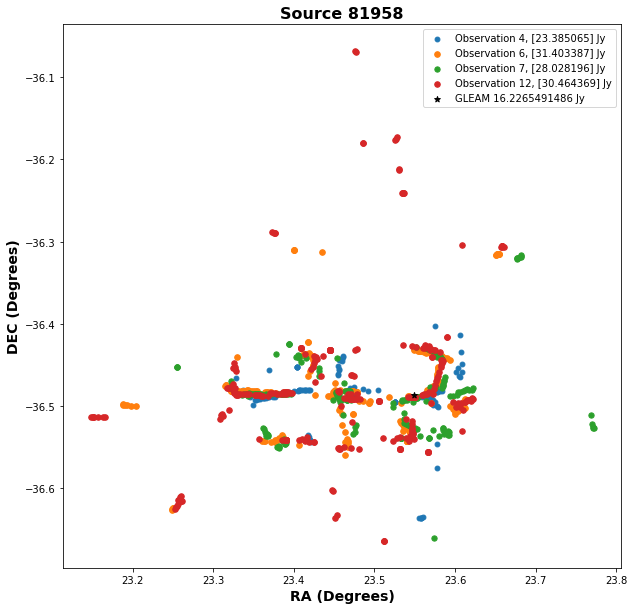

In [11]:
index = 81958

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

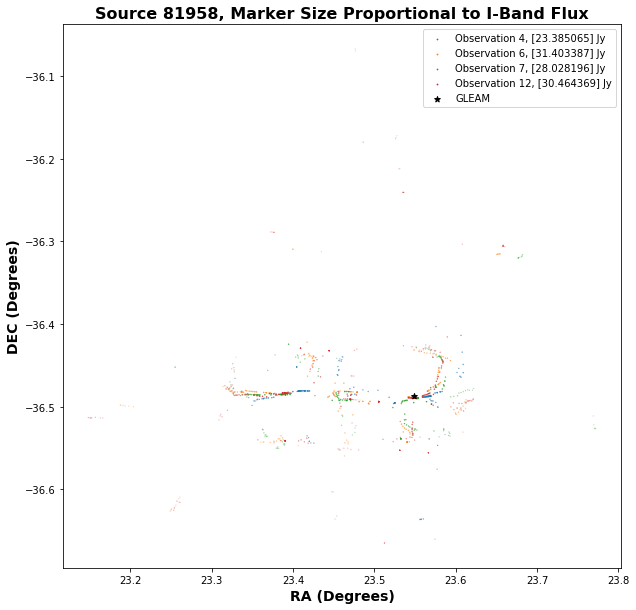

In [87]:
index = 81958

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], 
                    label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', label = 'GLEAM')
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}, Marker Size Proportional to I-Band Flux'.format(index))
plt.legend();

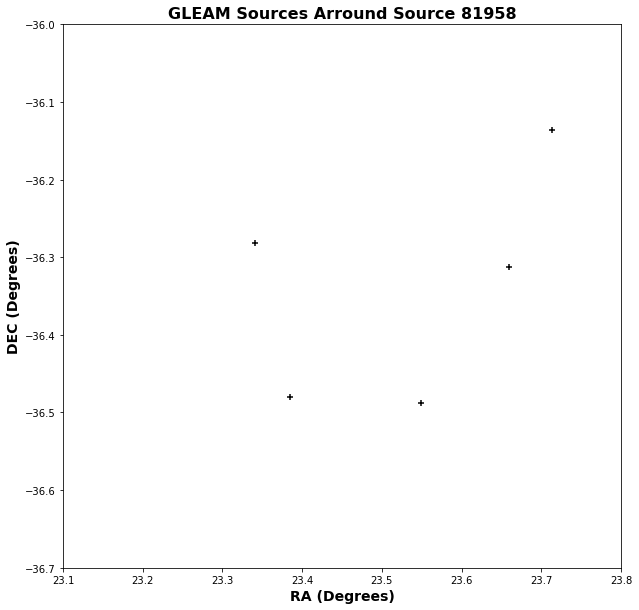

In [88]:
index = 81958
plt.scatter(table['RA'], table['DEC'], marker = '+', color = 'k')
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('GLEAM Sources Arround Source {}'.format(index))
plt.xlim(23.1, 23.8)
plt.ylim(-36.7, -36);

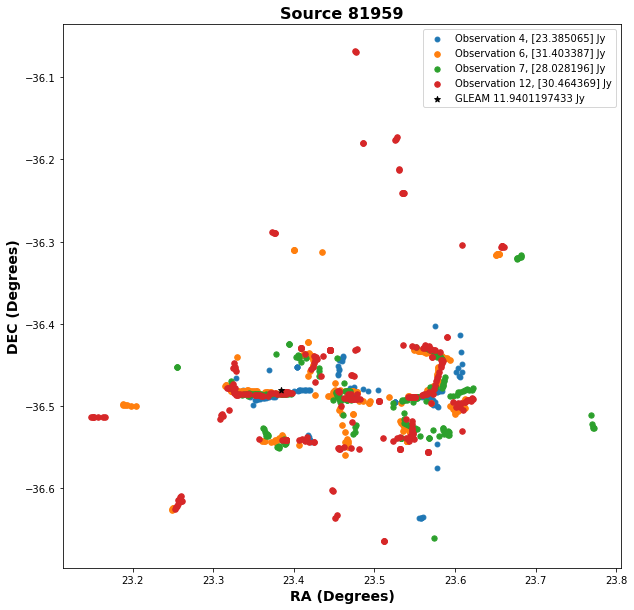

In [138]:
index = 81959

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

#NGC 612 http://simbad.u-strasbg.fr/simbad/sim-id?Ident=%401200203&Name=NGC%20%20%20612&submit=submit

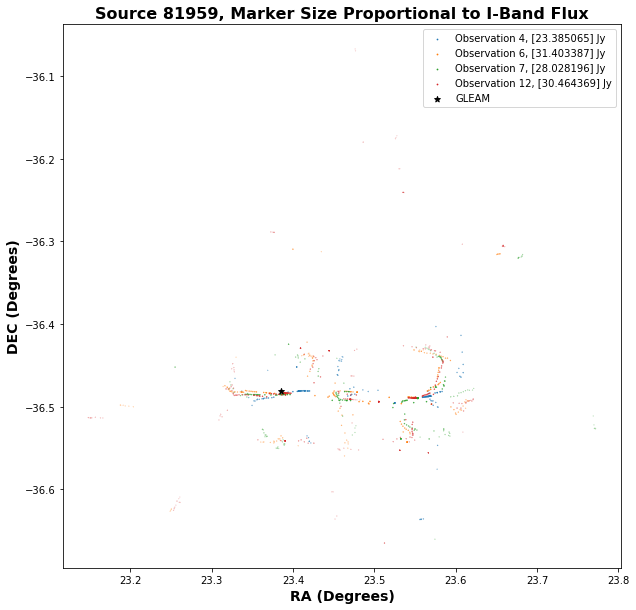

In [90]:
index = 81959

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], 
                    label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', label = 'GLEAM')
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}, Marker Size Proportional to I-Band Flux'.format(index))
plt.legend();

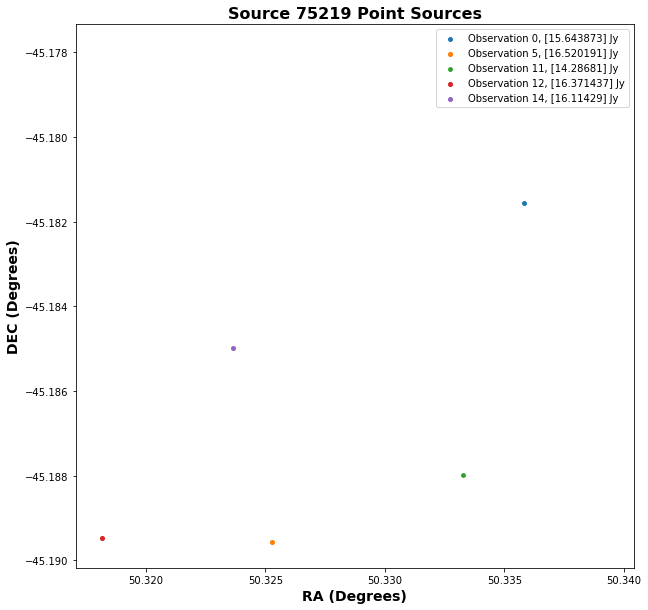

In [91]:
mags = table.loc[75219][3::7]
ras = table.loc[75219][5::7]
decs = table.loc[75219][6::7]
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i, mags[i]))
        plt.legend()
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {} Point Sources'.format(75219));

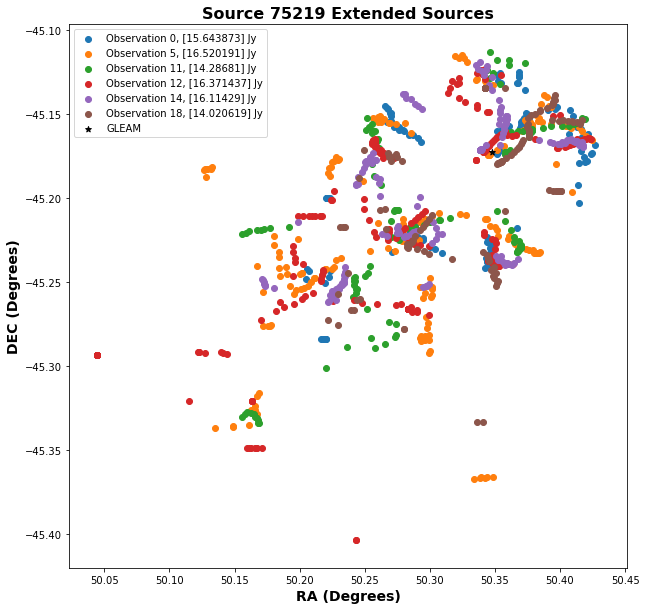

In [12]:
mags = table.loc[75219][3::7]
mags_eo = table.loc[75219][9::7]
ras = np.array(table.loc[75219][7::7])
decs = np.array(table.loc[75219][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], label = 'Observation {}, {} Jy'.format(i, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.legend();
plt.scatter(table.loc[75219]['RA'], table.loc[75219]['DEC'], color = 'k', marker = '*', label = 'GLEAM')
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {} Extended Sources'.format(75219))
plt.legend();

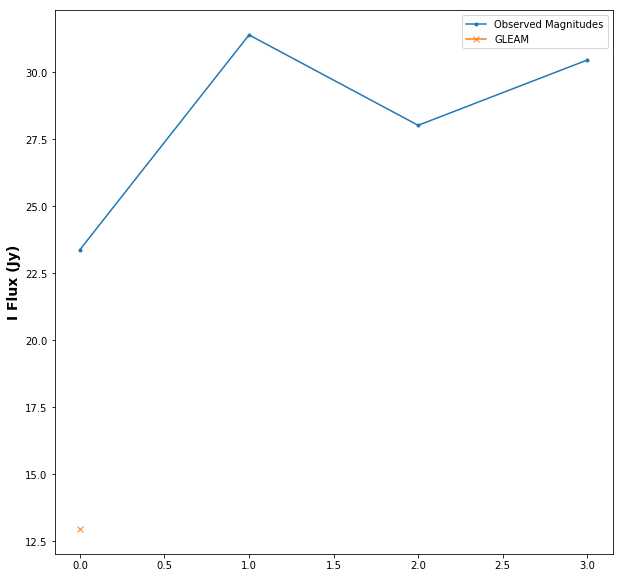

In [67]:
plt.plot(mag_change, marker = '.', label = 'Observed Magnitudes')
plt.plot(table.loc[75219]['Mag GLEAM'], label = 'GLEAM', marker = 'x')
plt.ylabel('I Flux (Jy)')
plt.legend();

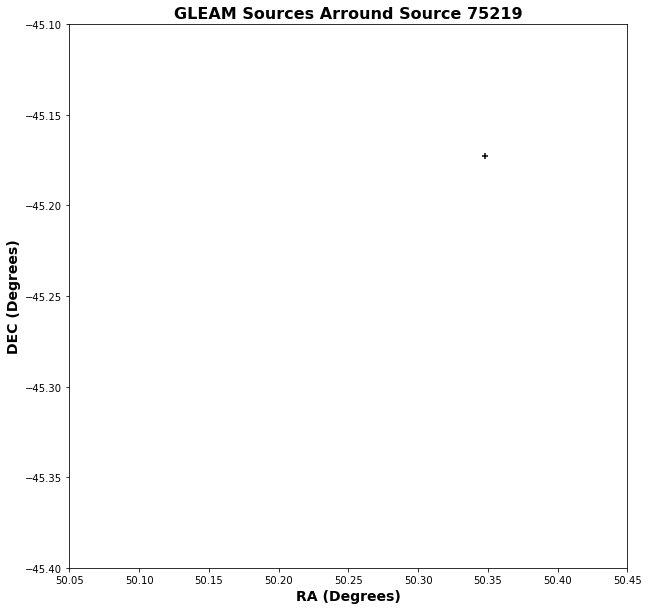

In [94]:
plt.scatter(table['RA'], table['DEC'], marker = '+', color = 'k')
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('GLEAM Sources Arround Source {}'.format(75219))
plt.xlim(50.05, 50.45)
plt.ylim(-45.40, -45.10);

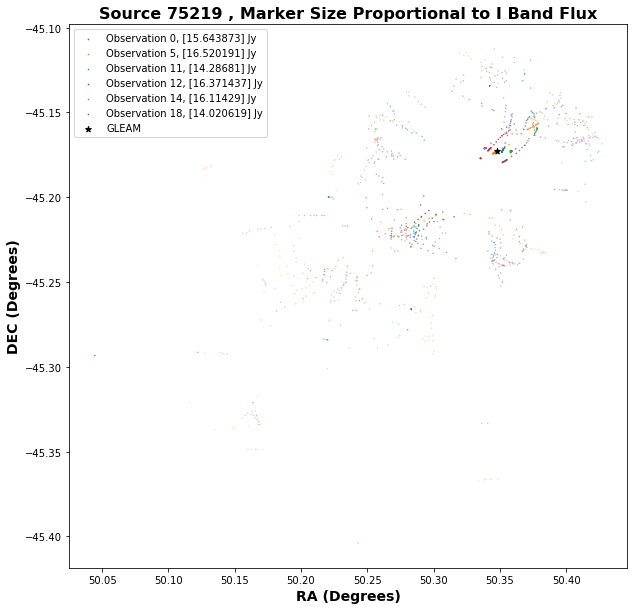

In [13]:
mags = table.loc[75219][3::7]
mags_eo = table.loc[75219][9::7]
ras = np.array(table.loc[75219][7::7])
decs = np.array(table.loc[75219][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], label = 'Observation {}, {} Jy'.format(i, mags[i]))
        plt.legend();
plt.scatter(table.loc[75219]['RA'], table.loc[75219]['DEC'], color = 'k', marker = '*', label = 'GLEAM')
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {} , Marker Size Proportional to I Band Flux'.format(75219))
plt.legend();

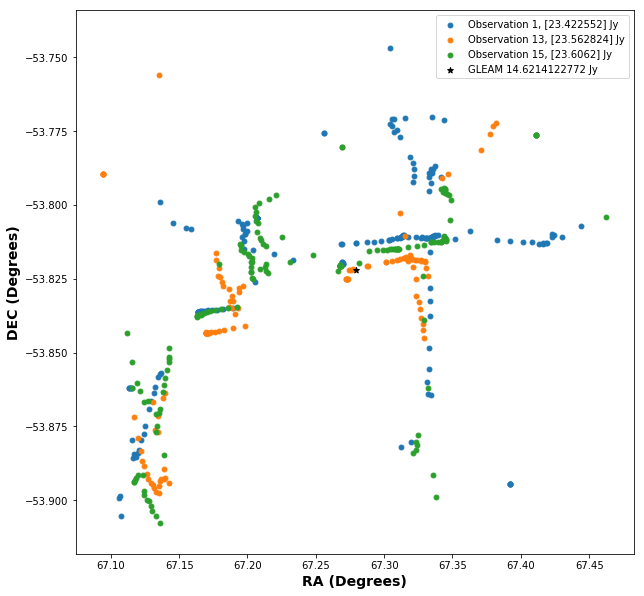

In [78]:
index = 63463

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.ylabel('DEC (Degrees)')
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.legend();

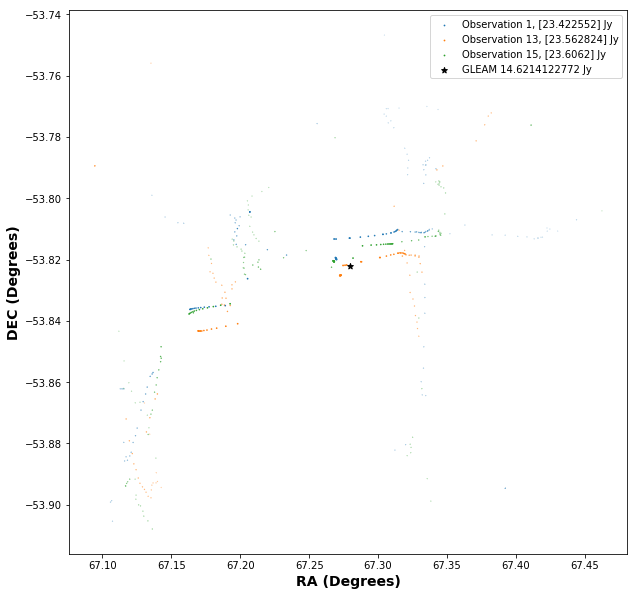

In [95]:
index = 63463

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.ylabel('DEC (Degrees)')
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.legend();

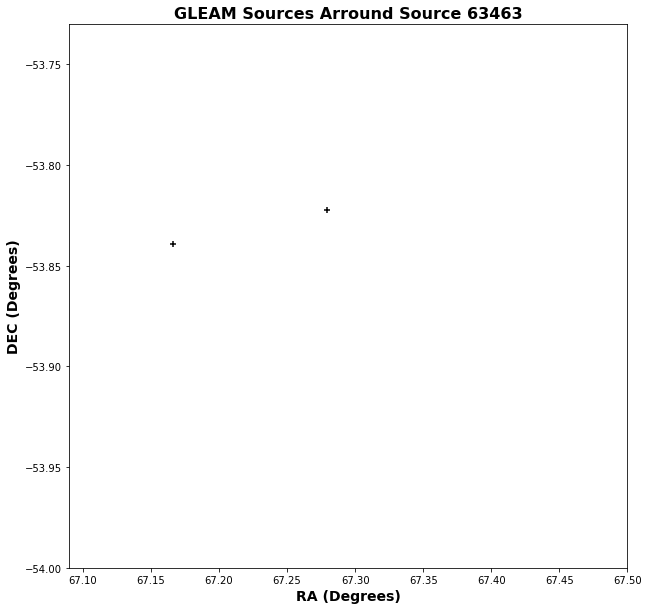

In [99]:
plt.scatter(table['RA'], table['DEC'], marker = '+', color = 'k')
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('GLEAM Sources Arround Source {}'.format(63463))
plt.xlim(67.09, 67.5)
plt.ylim(-54, -53.73);

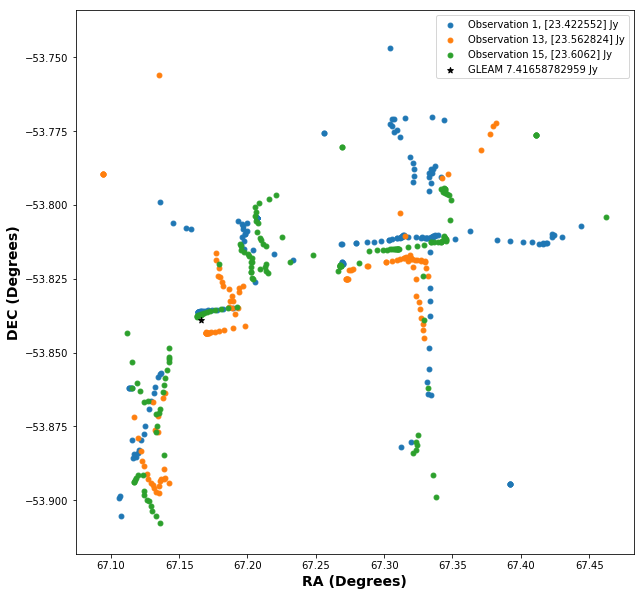

In [79]:
index = 63464

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.ylabel('DEC (Degrees)')
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.legend();

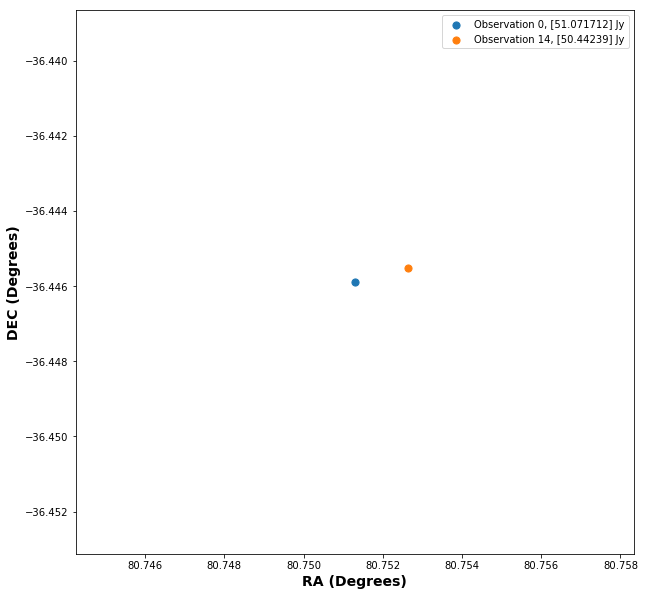

In [16]:
mags = table.loc[86043][3::7]
ras = table.loc[86043][5::7]
decs = table.loc[86043][6::7]
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.ylabel('DEC (Degrees)')
        plt.legend();

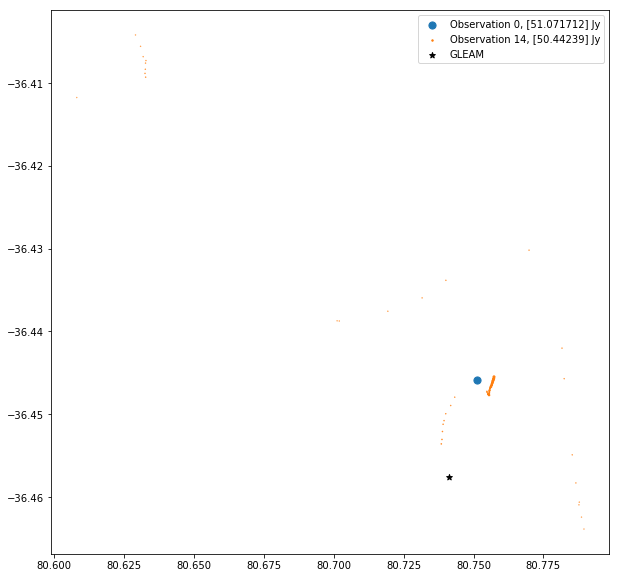

In [18]:
mags = table.loc[86043][3::7]
ras = table.loc[86043][5::7]
decs = table.loc[86043][6::7]
mags_eo = table.loc[86043][9::7]
ras_eo = np.array(table.loc[86043][7::7])
decs_eo = np.array(table.loc[86043][8::7])
mag_change = []
plt.scatter(ras[0], decs[0], s = mags[0], label = 'Observation 0, {} Jy'.format(mags[0]))
plt.scatter(ras_eo[14], decs_eo[14], s = mags_eo[14], label = 'Observation 14, {} Jy'.format(mags[14]))
#plt.scatter(ras_eo[15], decs_eo[15], s = mags[15],   label = 'Observation 15, {} Jy'.format(mags[15]))
#plt.scatter(ras_eo[18], decs_eo[18], s = mags[18], label = 'Observation 18, {} Jy'.format(mags[18]))
#plt.scatter(ras_eo[20], decs_eo[20],  label = 'Observation 0, {} Jy'.format(mags[20]))
plt.scatter(table.loc[86043]['RA'], table.loc[86043]['DEC'], color = 'k', marker = '*', label = 'GLEAM')
plt.legend();

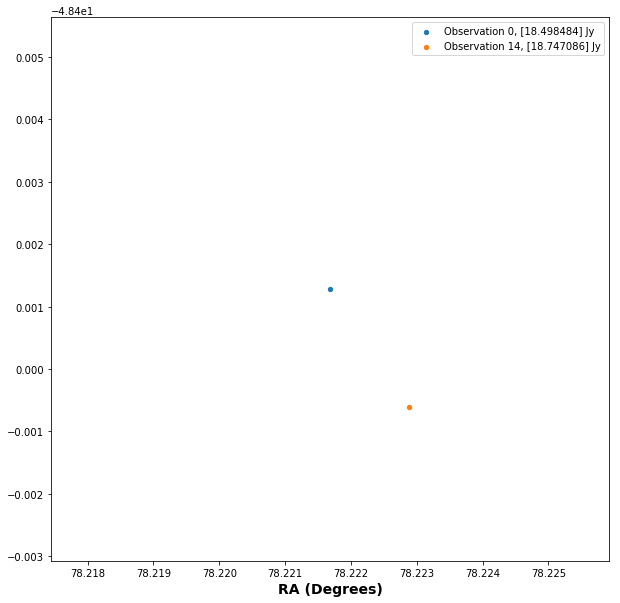

In [35]:
mags = table.loc[68949][3::7]
ras = table.loc[68949][5::7]
decs = table.loc[68949][6::7]
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.legend();

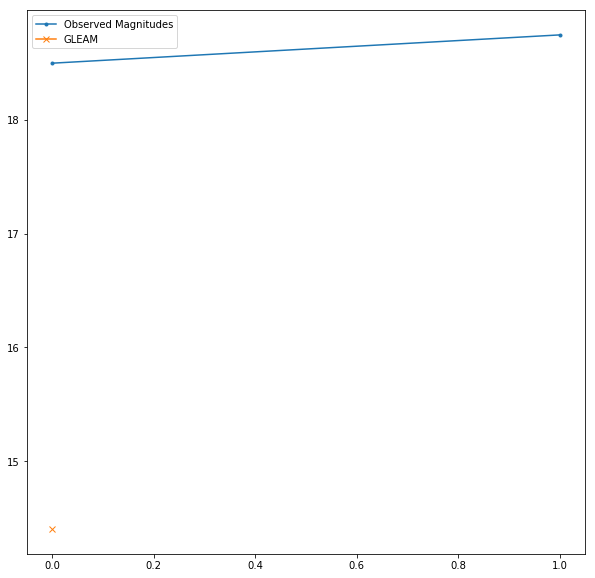

In [20]:
plt.plot(mag_change, marker = '.', label = 'Observed Magnitudes')
plt.plot(table.loc[68949]['Mag GLEAM'], label = 'GLEAM', marker = 'x')
#plt.ylabel('y')
plt.legend();

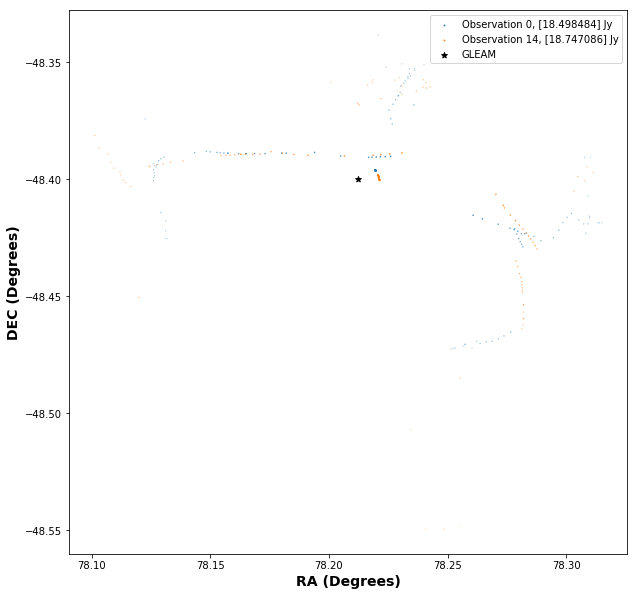

In [19]:
mags = table.loc[68949][3::7]
mags_eo = table.loc[68949][9::7]
ras = np.array(table.loc[68949][7::7])
decs = np.array(table.loc[68949][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], label = 'Observation {}, {} Jy'.format(i, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.ylabel('DEC (Degrees)')
        plt.legend();
plt.scatter(table.loc[68949]['RA'], table.loc[68949]['DEC'], color = 'k', marker = '*', label = 'GLEAM')
plt.legend();

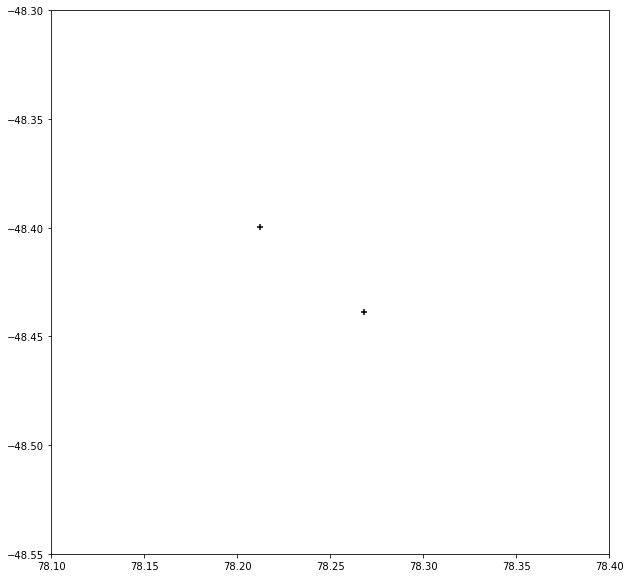

In [107]:
plt.scatter(table['RA'], table['DEC'], marker = '+', color = 'k')
plt.xlim(78.10, 78.4)
plt.ylim(-48.55, -48.3);

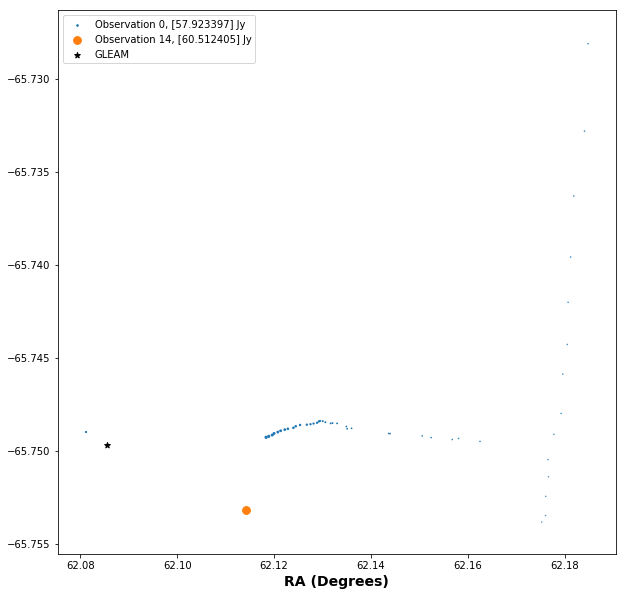

In [21]:
mags = table.loc[50185][3::7]
mags_eo = table.loc[50185][9::7]
ras = np.array(table.loc[50185][7::7])
decs = np.array(table.loc[50185][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], label = 'Observation {}, {} Jy'.format(i, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.legend();
plt.scatter(table.loc[50185]['RA'], table.loc[50185]['DEC'], color = 'k', marker = '*', label = 'GLEAM')
plt.legend();

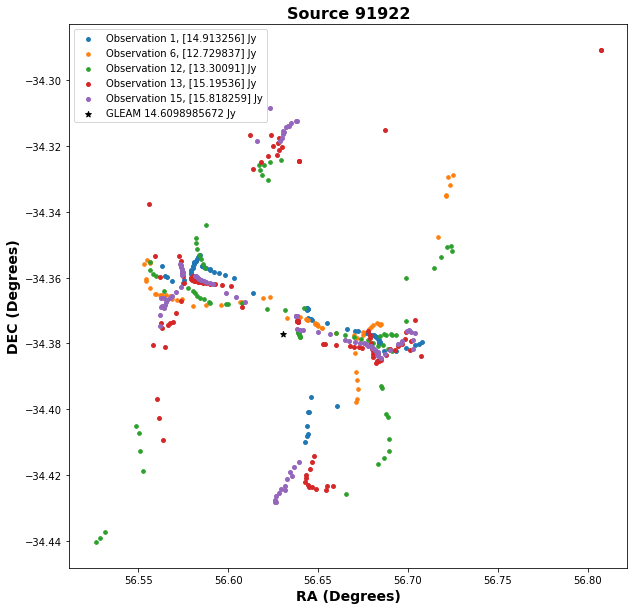

In [101]:
index = 91922

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

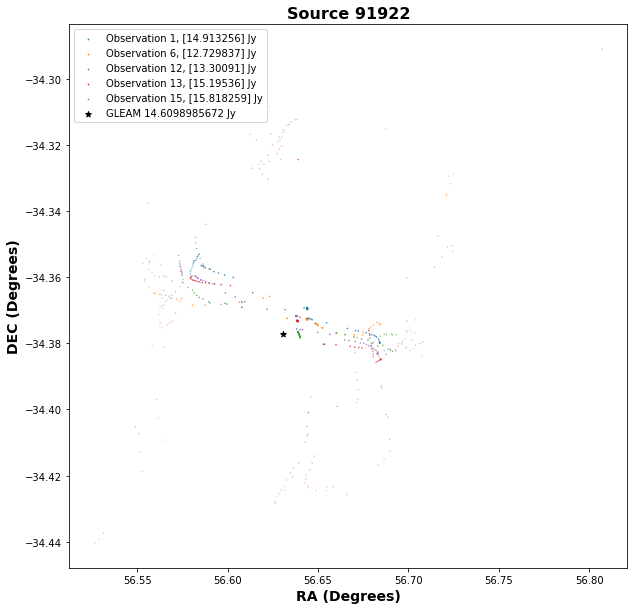

In [305]:
index = 91922

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.ylabel('DEC (Degrees)')
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.title('Source {}'.format(index))
plt.legend();

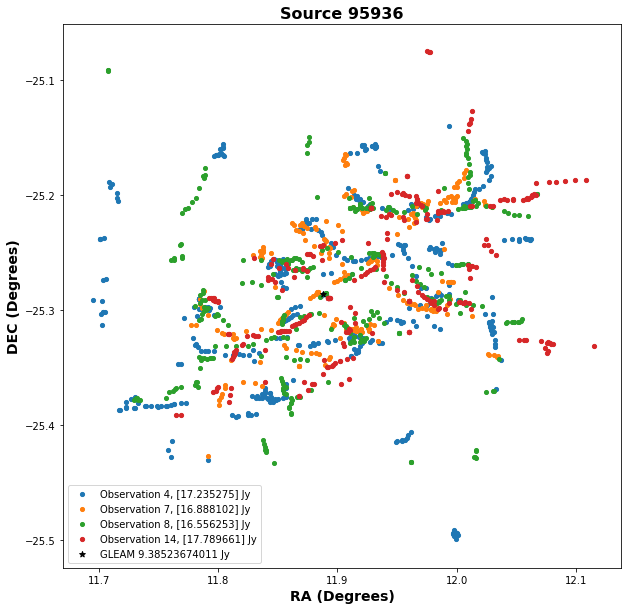

In [109]:
index = 95936

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

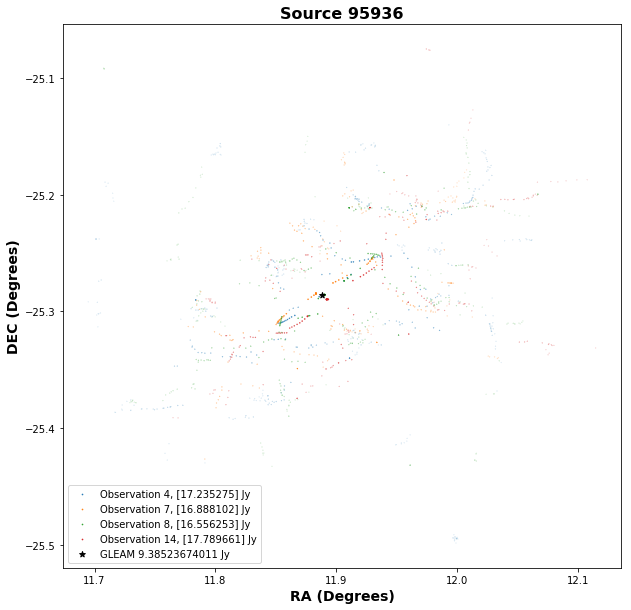

In [110]:
index = 95936

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

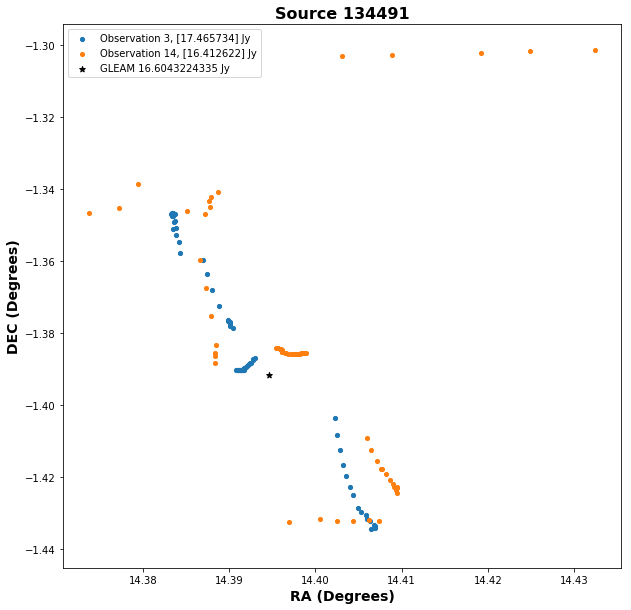

In [125]:
index = 134491

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

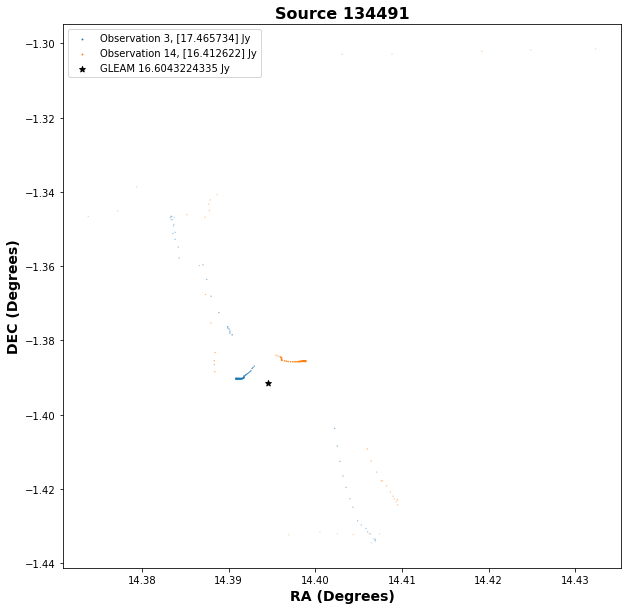

In [136]:
index = 134491

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

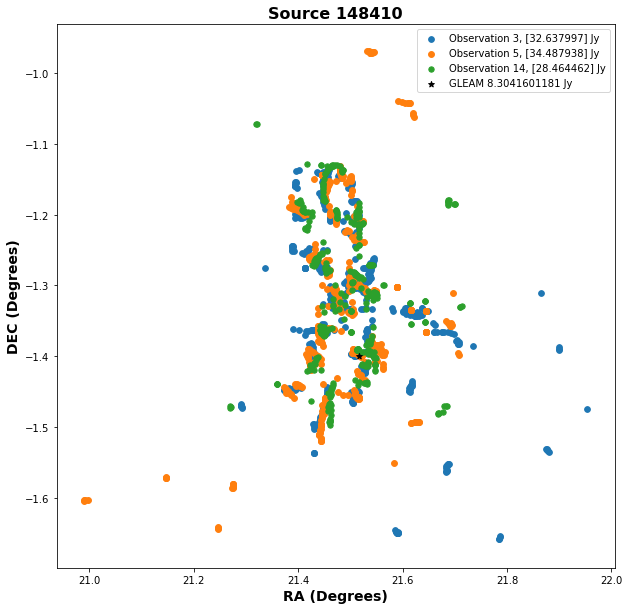

In [127]:
index = 148410

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

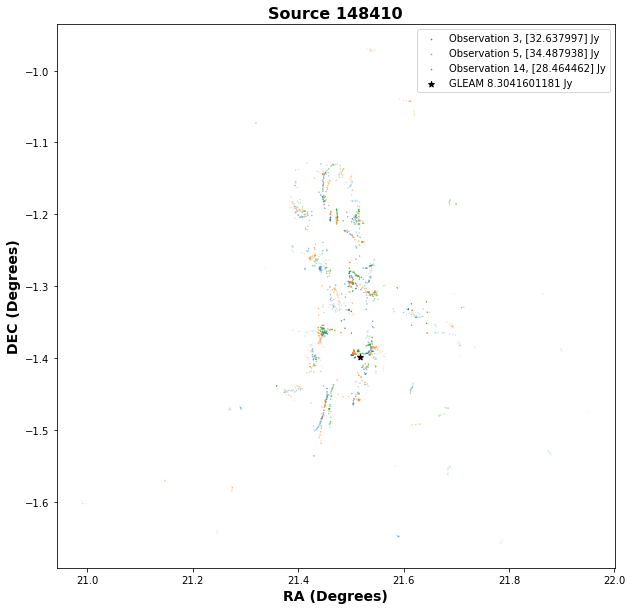

In [128]:
index = 148410

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags_eo[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

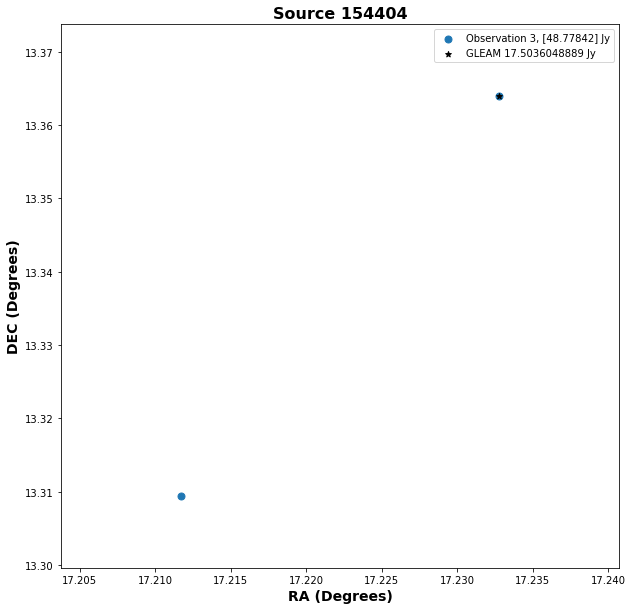

In [135]:
index = 154404

mags = table.loc[index][3::7]
mags_eo = table.loc[index][9::7]
ras = np.array(table.loc[index][7::7])
decs = np.array(table.loc[index][8::7])
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        plt.legend();
plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', 
            label = 'GLEAM {} Jy'.format(table.loc[index]['Mag GLEAM']))
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Source {}'.format(index))
plt.legend();

## Source Smoothing

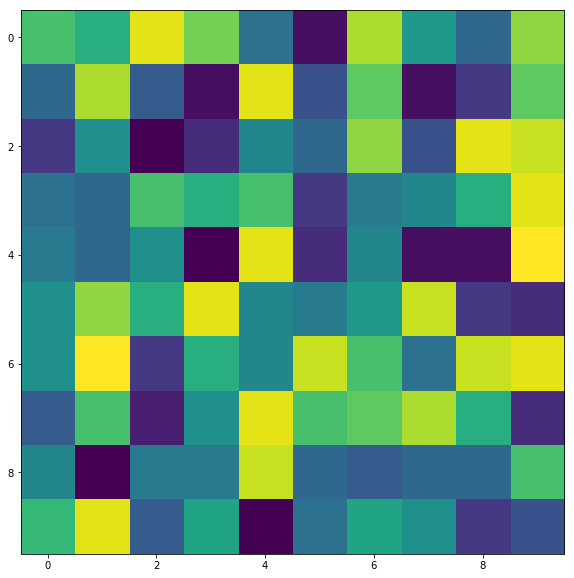

In [70]:
x = np.matrix(np.random.randint(25, size = (10, 10)))
plt.imshow(x);

In [205]:
data = np.matrix(np.zeros((100,100)))
data.shape

(100, 100)

In [24]:
mags = table.loc[75219][3::7]
mags_eo = table.loc[75219][9::7]
ras = np.array(table.loc[75219][7::7])
decs = np.array(table.loc[75219][8::7])
mag_change = []
image_ra = []
image_dec = []
image_mag = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        image_ra.append(ras[i])
        image_dec.append(decs[i])
        image_mag.append(mags_eo[i])

In [25]:
np.array(image_ra)

array([array([50.351448, 50.35148 , 50.351566, 50.351578, 50.351765, 50.351906,
       50.35206 , 50.35221 , 50.352283, 50.35255 , 50.352833, 50.353092,
       50.353447, 50.353806, 50.35134 , 50.29066 , 50.35508 , 50.288677,
       50.35797 , 50.28874 , 50.360798, 50.28756 , 50.36909 , 50.286404,
       50.369667, 50.286156, 50.370083, 50.370823, 50.28551 , 50.37139 ,
       50.284763, 50.372334, 50.279335, 50.376305, 50.283108, 50.37627 ,
       50.284973, 50.286713, 50.375675, 50.288593, 50.374847, 50.2909  ,
       50.37424 , 50.294365, 50.37363 , 50.292942, 50.29458 , 50.291225,
       50.390915, 50.300426, 50.286934, 50.39645 , 50.304268, 50.283703,
       50.39745 , 50.28014 , 50.40736 , 50.309685, 50.40645 , 50.27902 ,
       50.367046, 50.410275, 50.276516, 50.4068  , 50.270676, 50.344135,
       50.27644 , 50.37312 , 50.40859 , 50.272102, 50.343643, 50.41334 ,
       50.22356 , 50.345394, 50.223244, 50.354824, 50.27047 , 50.345814,
       50.22224 , 50.4159  , 50.34671 , 50.3

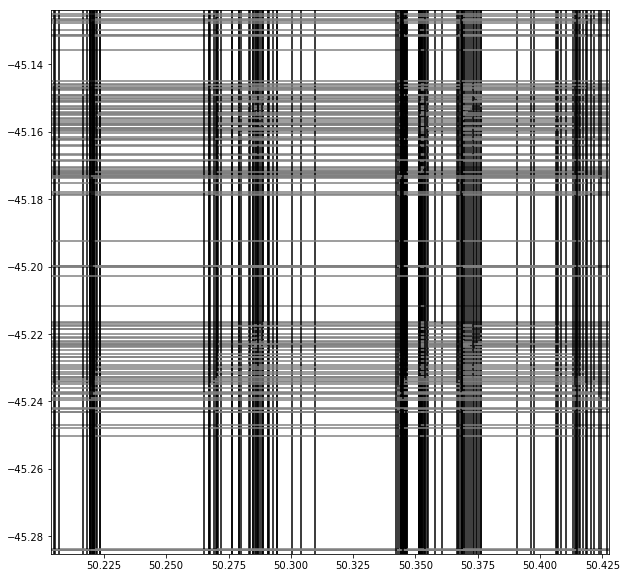

In [56]:
x = np.array(np.array_split(image_ra, 100))
y = np.array(np.array_split(image_dec, 100))
x_axis = x[0][0]
y_axis = y[0][0]
for i in range(0, len(x_axis)):
    plt.axvline(x_axis[i], color = 'k')
    plt.axhline(y_axis[i], color = 'grey')
    plt.xlim(np.min(image_ra[0])-0.001, np.max(image_ra[0])+0.001)
    plt.ylim(np.min(image_dec[0])-0.001, np.max(image_dec[0])+0.001)

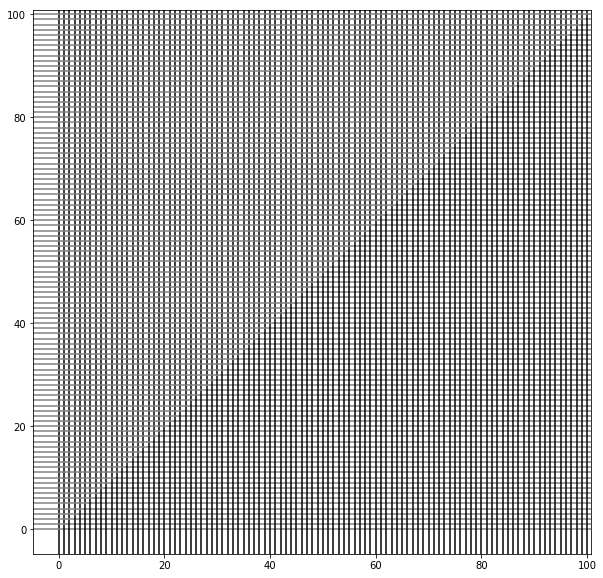

In [146]:
pixel_bound_x = np.arange(0, 101, 1)
pixel_bound_y = np.arange(0, 101, 1)
for i in range(0, len(pixel_bound_x)):
    plt.axvline(pixel_bound_x[i], color = 'k')
    plt.axhline(pixel_bound_y[i], color = 'grey')

In [208]:
ra = image_ra[0]
dec = image_dec[0]
xmin = np.min(ra)
xmax = np.max(ra)
ymin = np.min(dec)
ymax = np.max(dec)
image_mag[0]

array([0.7375405], dtype=float32)

In [277]:
xmins = []
xmaxs = []
ymins = []
ymaxs = []
for i in range(0, len(image_ra)):
    xmins.append(np.min(image_ra[i]))
    xmaxs.append(np.max(image_ra[i]))
    ymins.append(np.min(image_dec[i]))
    ymaxs.append(np.max(image_dec[i]))
xmin = np.min(xmins)
xmax = np.max(xmaxs)
ymin = np.min(ymins)
ymax = np.max(ymaxs)

In [278]:
data = np.matrix(np.zeros((100,100)))
x_axis = np.linspace(xmin - 0.001, xmax + 0.001, num=100, endpoint=True)
y_axis = np.linspace(ymin - 0.001, ymax + 0.001, num=100, endpoint=True)

for m in range(0, len(image_ra)):
    ra = image_ra[m]
    dec = image_dec[m]
    mag = image_mag[m]
    for i in range(0, len(ra)):
        pos_mag = mag[i]
        for j in range (0, len(x_axis)):
            if x_axis[j] < ra[i] and x_axis[j+1] > ra[i]:
                x_pos = j
        for k in range(0, len(y_axis)):
            if y_axis[k] < dec[i] and y_axis[k+1] > dec[i]:
                y_pos = k
        data[x_pos, y_pos] =  data[x_pos, y_pos] + pos_mag[0]

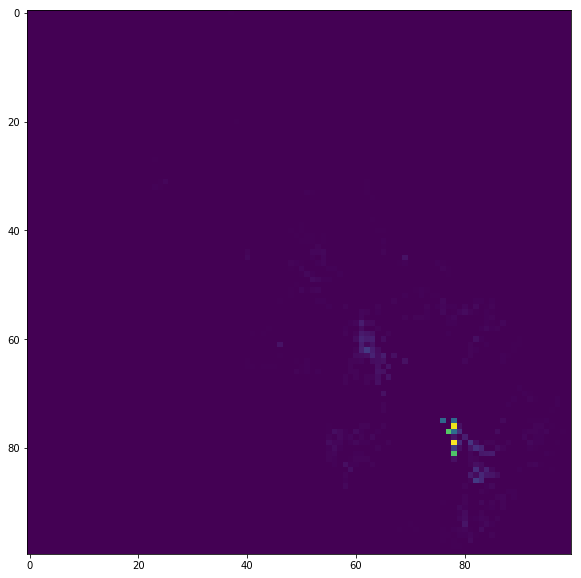

In [279]:
plt.imshow(data);

In [39]:
def pixel_image(table, index):
    """
    table is a Pandas DataFrame generated by the match_to_GELAM function
    
    index is the index of the object to be imaged
    """
    mags = table.loc[index][3::7]
    mags_eo = table.loc[index][9::7]
    ras = np.array(table.loc[index][7::7])
    decs = np.array(table.loc[index][8::7])
    mag_change = []
    image_ra = []
    image_dec = []
    image_mag = []
    for n in range(0, len(mags)):
        if mags[n] !=0:
            image_ra.append(ras[n])
            image_dec.append(decs[n])
            image_mag.append(mags_eo[n])
                
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    for i in range(0, len(image_ra)):
        xmins.append(np.min(image_ra[i]))
        xmaxs.append(np.max(image_ra[i]))
        ymins.append(np.min(image_dec[i]))
        ymaxs.append(np.max(image_dec[i]))
    xmin = np.min(xmins)
    xmax = np.max(xmaxs)
    ymin = np.min(ymins)
    ymax = np.max(ymaxs)
    
    data = np.matrix(np.zeros((100,100)))
    
    x_axis = np.linspace(xmin - 0.001, xmax + 0.001, num=100, endpoint=True)
    y_axis = np.linspace(ymin - 0.001, ymax + 0.001, num=100, endpoint=True)

    for m in range(0, len(image_ra)):
        ra = image_ra[m]
        dec = image_dec[m]
        mag = image_mag[m]
        for i in range(0, len(ra)):
            pos_mag = mag[i]
            for j in range (0, len(x_axis)):
                if x_axis[j] < ra[i] and x_axis[j+1] > ra[i]:
                    x_pos = j
            for k in range(0, len(y_axis)):
                if y_axis[k] < dec[i] and y_axis[k+1] > dec[i]:
                    y_pos = k
            data[x_pos, y_pos] =  data[x_pos, y_pos] + pos_mag[0]
       
    return plt.imshow(data)         

In [40]:
pixel_image(table, 75219)
plt.colorbar()
plt.clim(0, 1)
plt.gca().invert_yaxis();

AttributeError: 'function' object has no attribute 'loc'

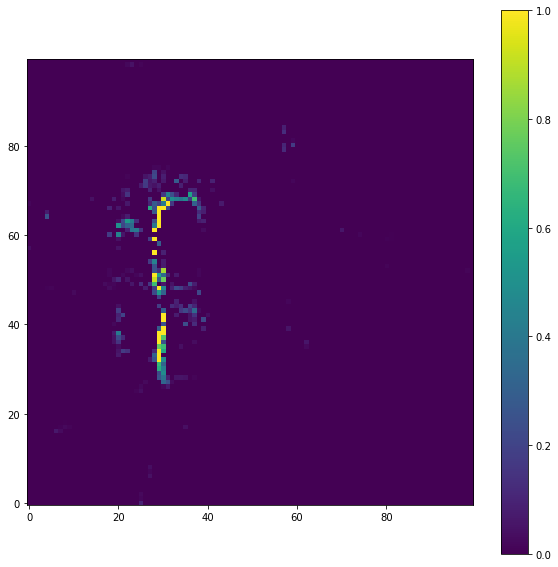

In [16]:
pixel_image(table, 81958)
plt.colorbar()
plt.clim(0, 1)
plt.gca().invert_yaxis();

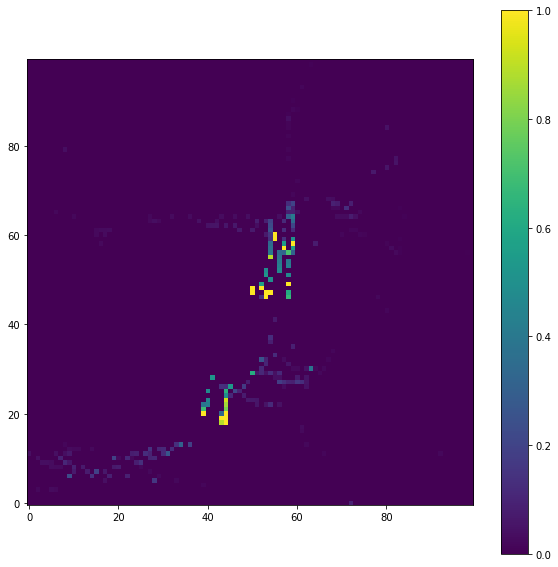

In [17]:
pixel_image(table, 63463)
plt.colorbar()
plt.clim(0, 1)
plt.gca().invert_yaxis();

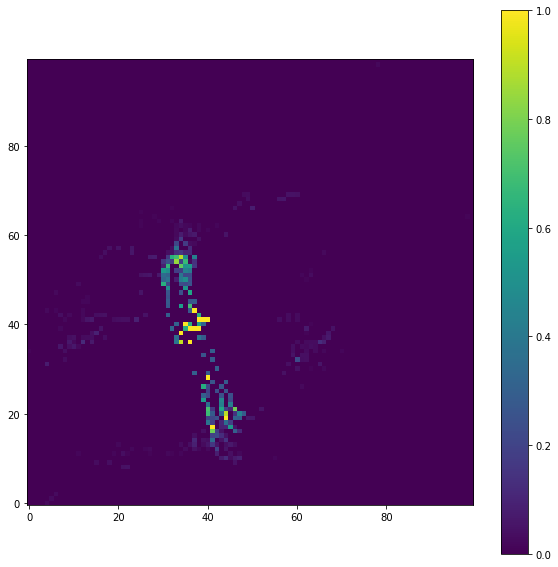

In [18]:
pixel_image(table, 91922)
plt.colorbar()
plt.clim(0, 1)
plt.gca().invert_yaxis();

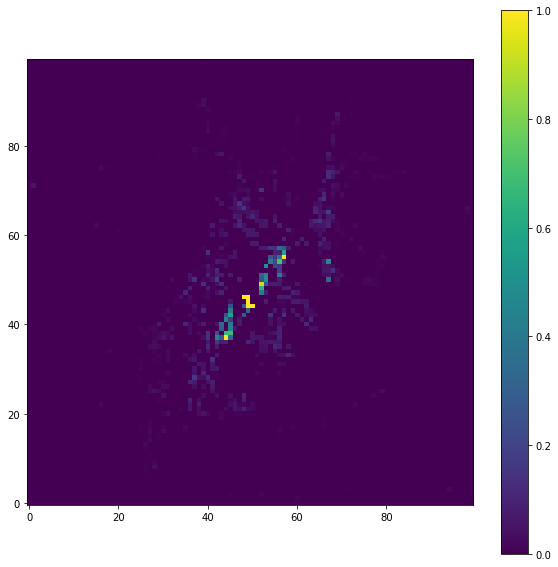

In [19]:
pixel_image(table, 95936)
plt.colorbar()
plt.clim(0, 1)
plt.gca().invert_yaxis();

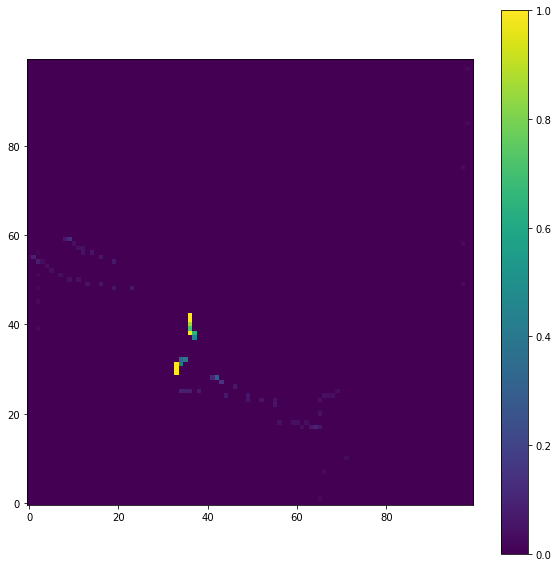

In [20]:
pixel_image(table, 134491)
plt.colorbar()
plt.clim(0, 1)
plt.gca().invert_yaxis();

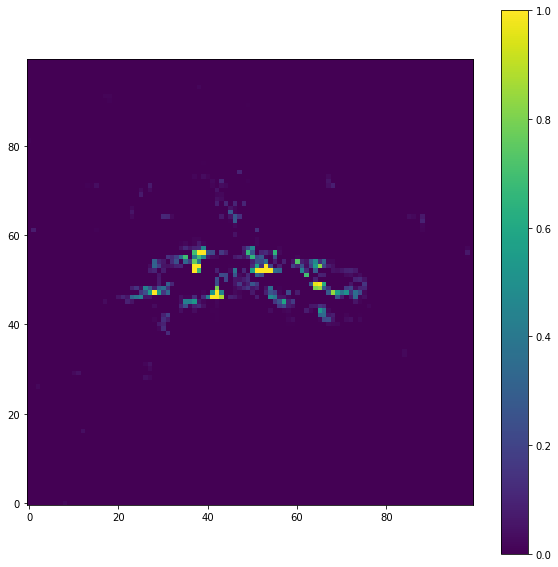

In [21]:
pixel_image(table, 148410)
plt.colorbar()
plt.clim(0, 1)
plt.gca().invert_yaxis();

Layer 0: points in permutation of a point (0,0):

In [38]:
comb = combinations([0,0], 2)
for i in comb:
    print(i)

(0, 0)


Layer 1: points touching the center point:

In [92]:
n = 1
startx = 0
starty = 0
xnums = []
ynums = []
nums = []
for i in range(0, n+1):
    nums.append(startx+i)
    nums.append(startx-i)
    nums.append(starty+i)
    nums.append(starty-i)

comb = combinations(nums, 2)
set(comb)

{(-1, -1), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 1)}

In [91]:
nums

[0, 0, 0, 0, 1, -1, 1, -1]

In [ ]:
def get_nth_layer(n)
"""
given n, returns the values for the nth layer of pixels around a point (j,k)

"""

